In [1]:
import os
from pydicom import dcmread
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate, iradon
import cv2
import numpy as np
from tqdm import tqdm
import polars as pl

import tigre
import numpy as np
from tigre.utilities import sample_loader
from tigre.utilities import CTnoise
import tigre.algorithms as algs

In [2]:
# _pth = os.path.join(os.path.dirname(os.getcwd()), 'dataset', '2')
_pth = r'/mnt/f/EPID Images/cube/854320164/'
# _pth = r'mnt\F\EPID Images\sphere\854320165'
_files = os.listdir(_pth)

In [3]:
print(os.getcwd())

/mnt/d/cmc/pyprojects/radio_therapy/dose-3d/notebooks


In [4]:
dcm = dcmread(os.path.join(_pth, _files[0]))

In [5]:
SID = dcm.RTImageSID
SAD = dcm.RadiationMachineSAD
print(SID, SAD)

1500.01179913412 1000


In [6]:
g_angle = []
_images = np.zeros((len(_files),300, 300), dtype=np.uint16)
prev = np.zeros((300, 300), dtype=np.uint16)
curr = np.zeros((300, 300), dtype=np.uint16)
_raw_datas = []
for idx, _fname in enumerate(tqdm(_files)):
    raw = dcmread(os.path.join(_pth, _fname))
    curr = raw.pixel_array
    
    curr = cv2.resize(curr, (300, 300), interpolation=cv2.INTER_CUBIC)
    _m = curr - prev
    if np.min(_m) > 10000:
        _images[idx, :, :] = _images[idx-1, :, :]
        g_angle.append(g_angle[idx-1])
    else:
        _images[idx, :, :] = curr - prev
        prev = curr
        g_angle.append(raw.GantryAngle)

100%|██████████| 580/580 [00:16<00:00, 34.98it/s]


In [7]:
g_angle = np.array(g_angle).astype(np.float32)
_images = np.array(_images).astype(np.float32)

In [8]:
def normalize_image(image):
    img_min = np.min(image)
    img_max = np.max(image)
    normalized_image = (image - img_min) / (img_max - img_min)
    return normalized_image

In [9]:
# _img = normalize_image(_images)
_img = _images

In [32]:
geo = tigre.geometry(
    mode="cone", nVoxel=np.array([300,300,580])
)
geo.DSD = float(SID)
geo.DSO = float(SAD)

In [33]:
# imgFBP = algs.fbp(_img, geo, g_angle)
imgFDK1 = algs.fdk(_img, geo, g_angle, filter="hann")
imgFDK2 = algs.fdk(_img, geo, g_angle, filter="ram_lak")

ValueError: operands could not be broadcast together with shapes (580,300,300) (0,0) (580,300,300) 

In [12]:
imgFBP2 = algs.ossart(_img, geo, g_angle, 5)


OSSART algorithm in progress.
Estimated time until completion : 00:00:24


In [13]:
(imgFBP2[:,:,150].max())

340.10263

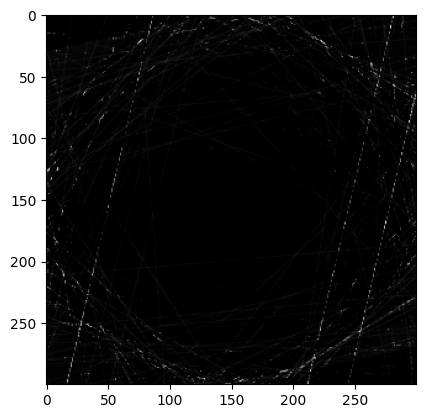

In [15]:
plt.imshow((imgFBP2[165,:,:].astype(np.uint8)), cmap='gray')